# Идентификация трещин на изображениях рельсов

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from skimage.io import imread_collection, imshow
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.exposure import adjust_log, adjust_gamma
from skimage.filters import threshold_mean

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D
        
import keras.backend as K
        
%matplotlib inline

## Подготавливаем набор данных

### Загрузим изображения и маски из датасета

In [2]:
images = imread_collection('dataset\Type-I RSDDs dataset\Rail surface images\*.jpg', True)[:118]
masks = imread_collection('dataset\Type-I RSDDs dataset\GroundTruth\*.jpg', True)

print('Изображений в датасете: {}, {}'.format(len(images), len(masks)))

Изображений в датасете: 67, 67


### Проведем аугментацию данных (случайные number_of_subsamples фрагментов изображения)

In [55]:
sample_size = 120
number_of_subsamples = 20

augmented_dataset = []

for i, img in enumerate(images):
    gray_image = rgb2gray(img)
    gray_mask = rgb2gray(masks[i])
    
    for _ in range(number_of_subsamples):
        # Получаем случайные координаты
        random_x = random.randint(0, gray_image.shape[1] - sample_size)
        random_y = random.randint(0, gray_image.shape[0] - sample_size)
        
        # Берем случайный квадрат изображения
        random_image_subsample = gray_image[random_y:random_y+sample_size, random_x:random_x+sample_size]
        random_mask_subsample = gray_mask[random_y:random_y+sample_size, random_x:random_x+sample_size]
        
        # Нормализуем маску
        thresh = threshold_mean(random_mask_subsample)
        random_mask_subsample = random_mask_subsample > thresh * 2
        
        # Проводим гамма коррекцию
        # random_image_subsample = adjust_gamma(random_image_subsample, 2)
        
        # Вращаем образцы
        for angle in [15, 25, 35, 45, 55, 65, 75, 85, 95, 185, 275]:
            rotated_random_image_subsample = rotate(random_image_subsample, angle)
            rotated_random_mask_subsample = rotate(random_mask_subsample, angle)
            augmented_dataset.append((rotated_random_image_subsample, rotated_random_mask_subsample))
        
        
        augmented_dataset.append((random_image_subsample, random_mask_subsample))

np.random.shuffle(augmented_dataset)
        
print('Размер набора данных: {}'.format(len(augmented_dataset)))

Размер набора данных: 16080


### Убираем малоинформативные блоки (трещина занимает менее 1% от площади изображения)

In [56]:
augmented_dataset = [d for d in augmented_dataset if np.count_nonzero(d[1]) / (sample_size * sample_size) >= 0.025]

np.save('dataset.npy', augmented_dataset)

print('Размер набора данных: {}'.format(len(augmented_dataset)))

Размер набора данных: 2024


### Посмотрим на результат аугментации

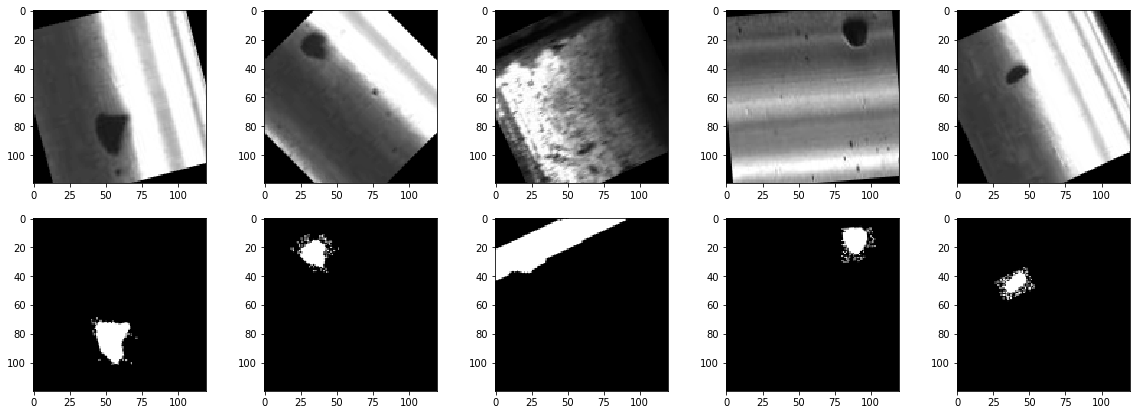

In [57]:
augmented_dataset = np.load('dataset.npy')

fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    rnd = np.random.randint(0, len(augmented_dataset))
    ax[0, i].imshow(augmented_dataset[rnd][0], cmap='gray')
    ax[1, i].imshow(augmented_dataset[rnd][1], cmap='gray')

### Подготовим данные для обучения

In [58]:
dataset = np.load('dataset.npy')

train_ratio = 0.95
train, test = dataset[:int(len(dataset) * train_ratio)], dataset[int(len(dataset) * train_ratio):]

train_x, train_y, test_x, test_y = train[:, 0], train[:, 1], test[:, 0], test[:, 1]

print('В обучающем наборе элементов: {}, в тестовом {}'.format(len(train_x), len(test_x)))

В обучающем наборе элементов: 1922, в тестовом 102


### Преобразуем данные к 4D формату

In [59]:
train_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in train_x])
train_y_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in train_y])
test_x_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in test_x])
test_y_norm = np.array([d.reshape((sample_size, sample_size, 1)) for d in test_y])

### Строим модель FCN-сети

In [34]:
model = Sequential()

model.add(Convolution2D(filters=32,
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=(sample_size, sample_size, 1),
                        padding='same'
                        ))

model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='sigmoid',
                        padding='same'
                        ))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Dense(64, activation='relu'))

model.add(Convolution2D(filters=1, 
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        padding='same'
                        ))

model.add(UpSampling2D(size=(2, 2)))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 120, 120, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 60, 60, 64)        4160      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 1)         577       
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 120, 120, 1)       0         
Total params: 23,553
Trainable params: 23,553
Non-trainable params: 0
_________________________________________________________________


### Обучаем нейронную сеть

In [60]:
history = model.fit(train_x_norm, train_y_norm, validation_data=(test_x_norm, test_y_norm), epochs=20, batch_size=10)

Train on 1922 samples, validate on 102 samples
Epoch 1/20
1922/1922 [==============================] - 95s 49ms/step - loss: 0.1112 - val_loss: 0.0944
Epoch 2/20
1922/1922 [==============================] - 100s 52ms/step - loss: 0.1086 - val_loss: 0.1296
Epoch 3/20
1922/1922 [==============================] - 101s 53ms/step - loss: 0.1073 - val_loss: 0.1016
Epoch 4/20
1922/1922 [==============================] - 101s 53ms/step - loss: 0.1051 - val_loss: 0.1673
Epoch 5/20
1922/1922 [==============================] - 104s 54ms/step - loss: 0.1038 - val_loss: 0.0950
Epoch 6/20
1922/1922 [==============================] - 97s 51ms/step - loss: 0.1032 - val_loss: 0.1051
Epoch 7/20
1922/1922 [==============================] - 90s 47ms/step - loss: 0.1007 - val_loss: 0.0928
Epoch 8/20
1922/1922 [==============================] - 88s 46ms/step - loss: 0.0999 - val_loss: 0.0918
Epoch 9/20
1922/1922 [==============================] - 89s 46ms/step - loss: 0.1000 - val_loss: 0.0873
Epoch 10/20
1

### Сохраняем нейронную сеть

In [61]:
model.save('network')

### Проводим валидацию на тестовой выборке

In [62]:
model = models.load_model('network')
results = model.predict(test_x_norm)

### Расчитываем ошибку и показываем результаты работы (по возрастанию ошибки)

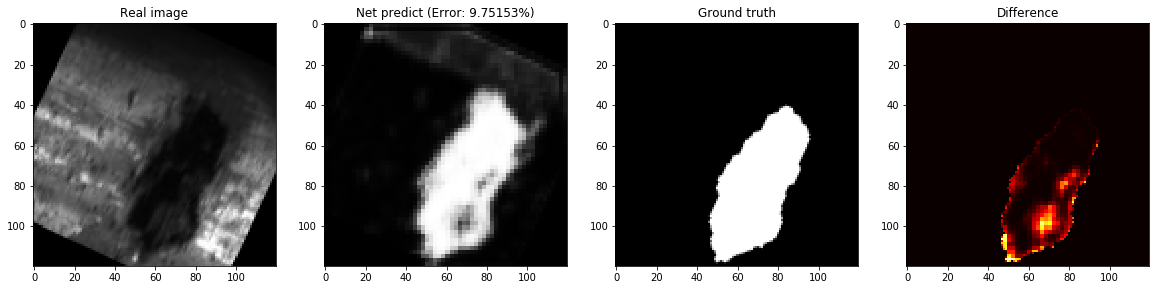

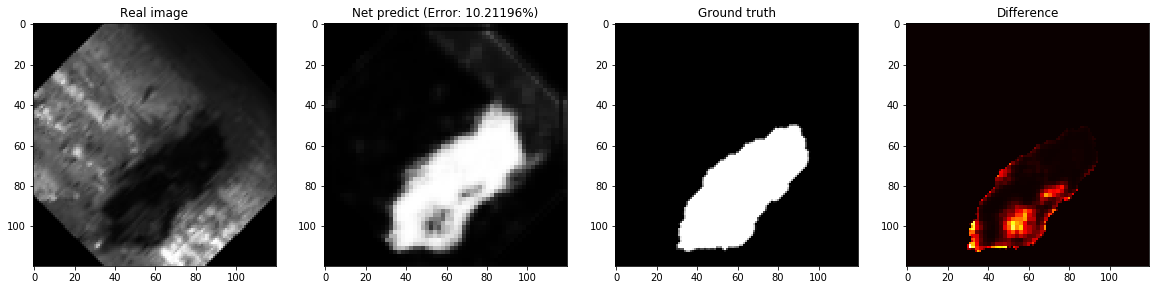

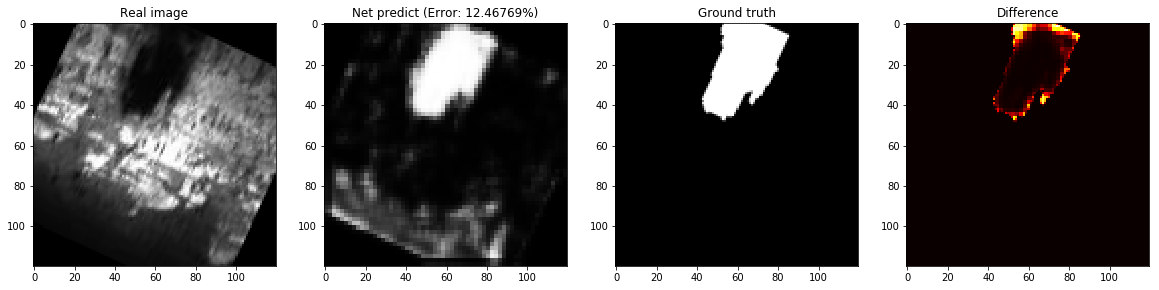

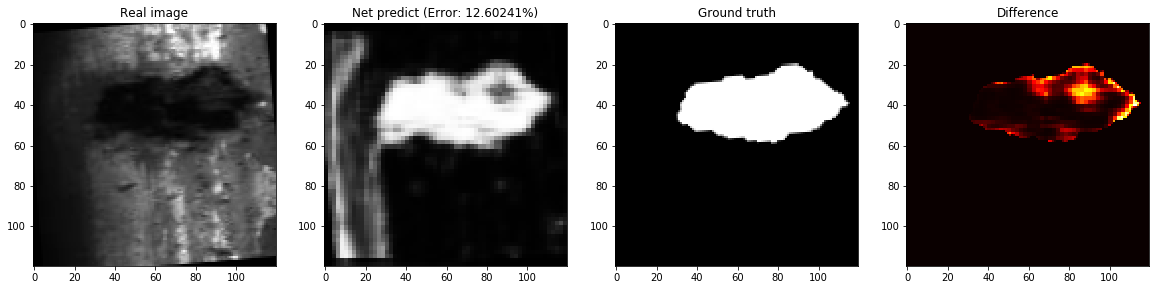

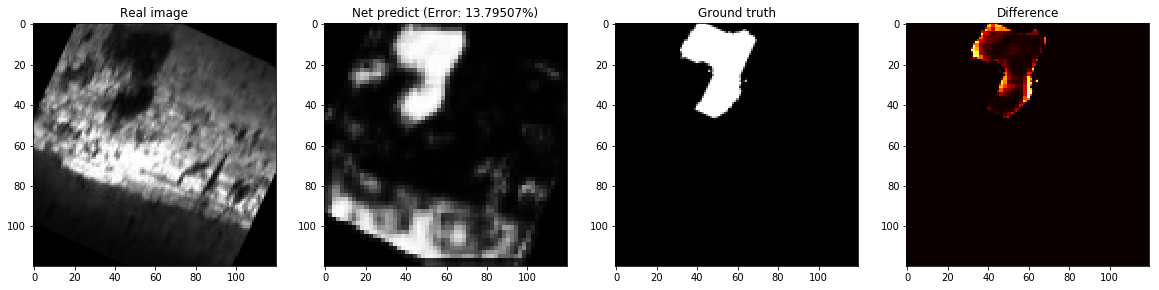

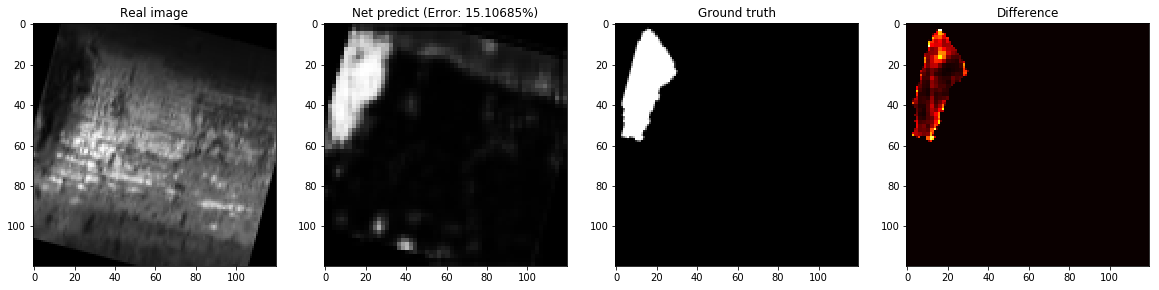

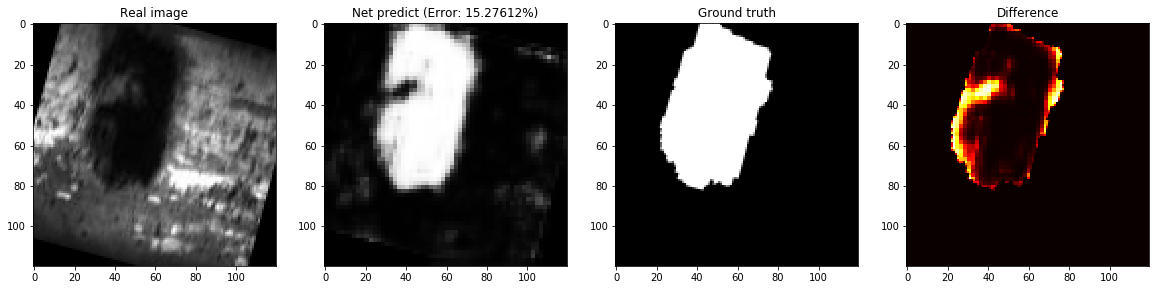

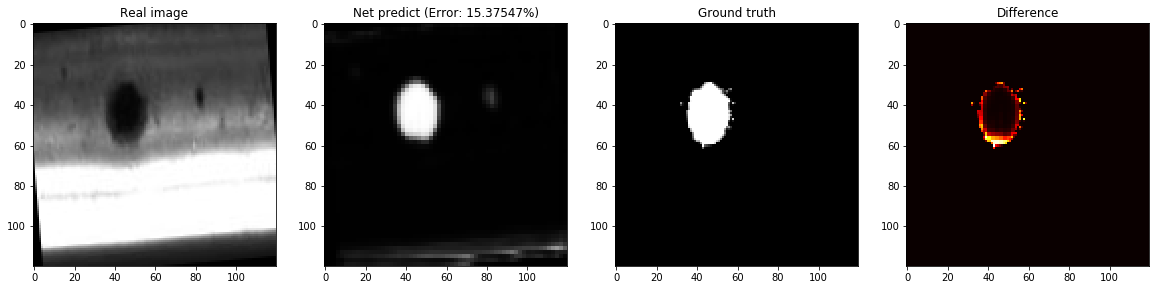

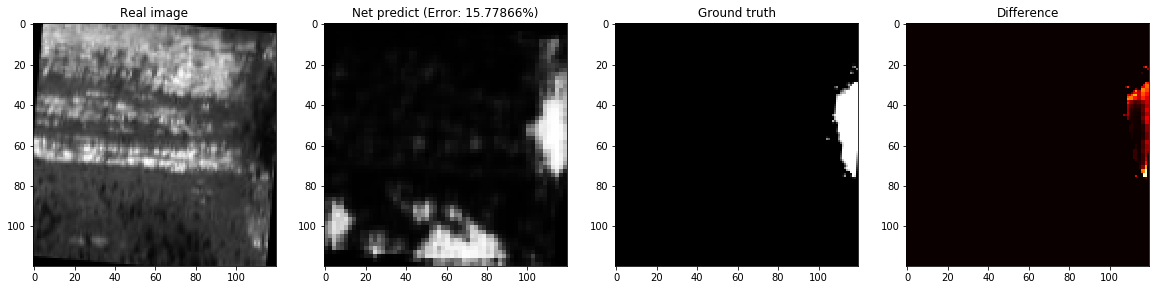

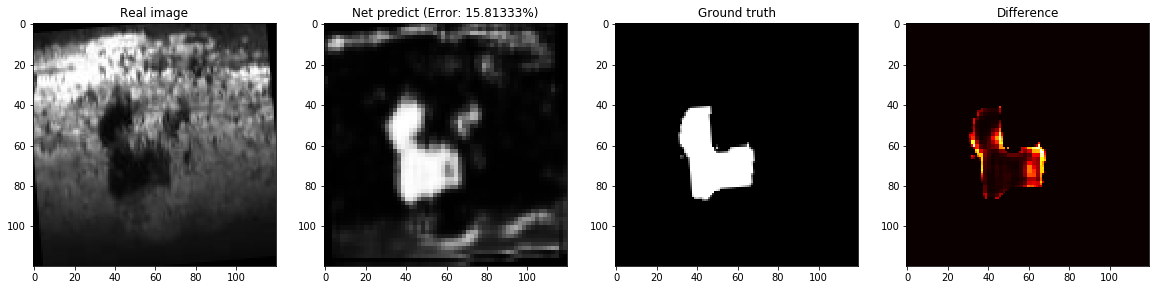

In [65]:
differences = []

for i in range(len(test_y_norm)):
    diff = test_y_norm[i] - results[i]
    diff[diff < 0] = 0
    error = np.average(diff[diff > 0])
    differences.append((i, error, diff))
    
differences = sorted(differences, key=lambda x: x[1], reverse=False)

for i, error, diff in differences[:10]:
    fig, ax = plt.subplots(1, 4, figsize=(20, 11))
    ax[0].set_title('Real image')
    ax[0].imshow(test_x_norm[i].reshape((sample_size, sample_size)), cmap='gray')
    ax[1].set_title('Net predict (Error: {}%)'.format(round(error * 100, 5)))
    ax[1].imshow(results[i].reshape((sample_size, sample_size)), cmap='gray')
    ax[2].set_title('Ground truth')
    ax[2].imshow(test_y_norm[i].reshape((sample_size, sample_size)), cmap='gray')
    ax[3].set_title('Difference')
    ax[3].imshow(diff.reshape((sample_size, sample_size)), cmap='hot')